# Creating Features Through Investigation

On this page, we will focus on creating new features other than the given columns in the dataset. 
Let's start with some simple hypothesis and investigate whether we can use our hypothesis to create a new feature.  

```{note}
This page corresponds to the "Power Feature" part of the original project. I will revise and fix some errors in the original project on this page and add new investigations for more features. 
```

## First Investigation: Relationship Between Location and Fraudulent Posting

The first hypothesis we will investigate is that **location, especially state, is related to whether the posting is fraudulent.** For example, many fake job postings might have come from California or New York since those states have more job availability than others due to their high population. If the location is significantly related to the fraudulent variable, we can extract the state from the location and use it as a feature. Let's investigate the relationship and see if the hypothesis is correct.  

```{note}
This part is not in the original project.
```

In [170]:
import pandas as pd 
import numpy as np
import re
from matplotlib import pyplot as plt

In [158]:
train_data = pd.read_csv("./data/train_set.csv")

To extract the state from the location, let's define the function to make the process easier.

```python
def extract_state(s):
    """ Extract state from the location"""
    """ The function can be used only when the state is formmated with two capital letter"""
    """ Input: Series, iterable object"""
    """ Output: List of States"""
    
    s.fillna("No Location", inplace = True)
    result = []    
    for i in np.arange(len(s)):
        if (s[i].__contains__("US")):
            extracted = re.findall(r'[A-Z]{2}', re.sub(r'[US]','',s[i]))
            # Edge Case 1: Posting is from US but State is not posted
            if extracted == []:
                extracted = ["Domestic"]
            # Edge Case 2: Regex detect a city name as a State name
            if len(extracted) != 1:
                while len(extracted) > 1:
                    extracted.pop()
            result += extracted
        else:
            # Edge Case 3: Location is not given 
            if s[i] == ["No Location"]:
                result += s[i]
            # Edge Case 4: Location is given but not in US
            elif re.findall(r'[A-Z]{2}', s[i]) != []:
                result += ["Foreign"]
            # Edge Case 5: Location cannot be identified from the given information
            else:
                result += ["No Location"]
    return result
```

In [159]:
def extract_state(s):
    """ Extract state from the location"""
    """ The function can be used only when the state is formmated with two capital letter"""
    """ Input: Series, iterable object"""
    """ Output: List of States"""
    
    s.fillna("No Location", inplace = True)
    result = []    
    for i in np.arange(len(s)):
        if (s[i].__contains__("US")):
            extracted = re.findall(r'[A-Z]{2}', re.sub(r'[US]','',s[i]))
            # Edge Case 1: Posting is from US but State is not posted
            if extracted == []:
                extracted = ["Domestic"]
            # Edge Case 2: Regex detect a city name as a State name
            if len(extracted) != 1:
                while len(extracted) > 1:
                    extracted.pop()
            result += extracted
        else:
            # Edge Case 3: Location is not given 
            if s[i] == ["No Location"]:
                result += s[i]
            # Edge Case 4: Location is given but not in US
            elif re.findall(r'[A-Z]{2}', s[i]) != []:
                result += ["Foreign"]
            # Edge Case 5: Location cannot be identified from the given information
            else:
                result += ["No Location"]
    return result

In [168]:
result = extract_state(train_data["location"])
train_data["state"] = result
train_data[["location", "state", "fraudulent"]]

,location,state,fraudulent
0,"US, VA, Virginia Beach",VA,0
1,"US, TX, Dallas",TX,0
2,"NZ, , Auckland",Foreign,0
3,"US, NE, Omaha",NE,0
4,"US, CA, Los Angeles",CA,0
...,...,...,...
14299,"US, CA, Irvine",CA,0
14300,"GR, I, Athens",Foreign,0
14301,"US, NJ, Elmwood Park",NJ,0
14302,"US, AZ, Phoenix",AZ,0


Now, let's use the extracted state to validate our hypothesis. 
First of all, let's observe the distribution of state in the entire dataset. 

### Distribution of Location: Entire Dataset

In [296]:
combined_data = train_data["state"].value_counts().to_frame()
combined_data = combined_data.reset_index().rename(columns = {'index':'state', 'state':'count'})
combined_data["percentage"] = (combined_data["count"] / combined_data["count"].sum()) * 100
combined_data.head(10)

,state,count,percentage
0,Foreign,5504,38.478747
1,CA,1617,11.304530
2,NY,1003,7.012025
3,TX,806,5.634787
4,Domestic,584,4.082774
5,IL,326,2.279083
6,FL,322,2.251119
7,OH,304,2.125280
8,No Location,280,1.957494
9,MA,262,1.831655


Text(0.5, 1.0, 'Percent Distribution of Location: Entire Dataset')

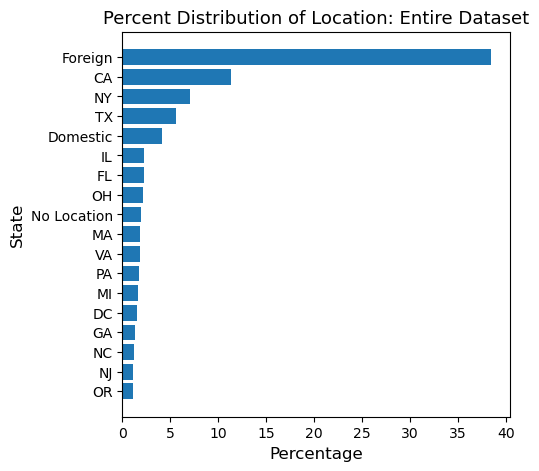

In [294]:
sorted_df = combined_data.sort_values('percentage')
sorted_df = sorted_df[sorted_df['percentage'] > 1]
x = sorted_df['state']
y = sorted_df['percentage']

plt.figure(figsize=(5,5))
plt.barh(x,y)
plt.xlabel("Percentage", size=12)
plt.ylabel("State", size=12)
plt.title("Percent Distribution of Location: Entire Dataset", size=13)

```{note}
Foreign: the job posting has a location outside of the US 

Domestic: the job posting has a US location, but a specific state name is not given

No Location: the job posting did not include a location
```

The distribution of the state of the entire dataset shows that about 40% of job posting is from companies outside the US, and about 20% of job posting is from either California or New York. The result is quite surprising because I was not expecting to see such a high number of 'foreign.'

Let's see if we see a notable difference in distribution when we split the dataset into fraudulent and non-fraudulent.

### Distribution of Location: Fraudulent and Non-Fraudulent Dataset

In [269]:
# Convinent function for data frame display 

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [297]:
fraud_data = train_data[train_data['fraudulent'] == 1]
non_fraud_data = train_data[train_data['fraudulent'] == 0]

f_combined_data = fraud_data["state"].value_counts().to_frame()
f_combined_data = f_combined_data.reset_index().rename(columns = {'index':'state', 'state':'count'})
f_combined_data["percentage"] = (f_combined_data["count"] / f_combined_data["count"].sum()) * 100

nf_combined_data = non_fraud_data["state"].value_counts().to_frame()
nf_combined_data = nf_combined_data.reset_index().rename(columns = {'index':'state', 'state':'count'})
nf_combined_data["percentage"] = (nf_combined_data["count"] / nf_combined_data["count"].sum()) * 100

display_side_by_side([nf_combined_data[0:10], f_combined_data[0:10]], ['Non-Fraudulent', 'Fraudulent'], tablespacing =20)

,state,count,percentage
0,Foreign,5407,39.725222
1,CA,1509,11.086621
2,NY,947,6.957608
3,TX,681,5.003306
4,Domestic,536,3.937991
5,IL,310,2.277570
6,FL,298,2.189406
7,OH,290,2.130630
8,No Location,264,1.939608
9,MA,253,1.858791


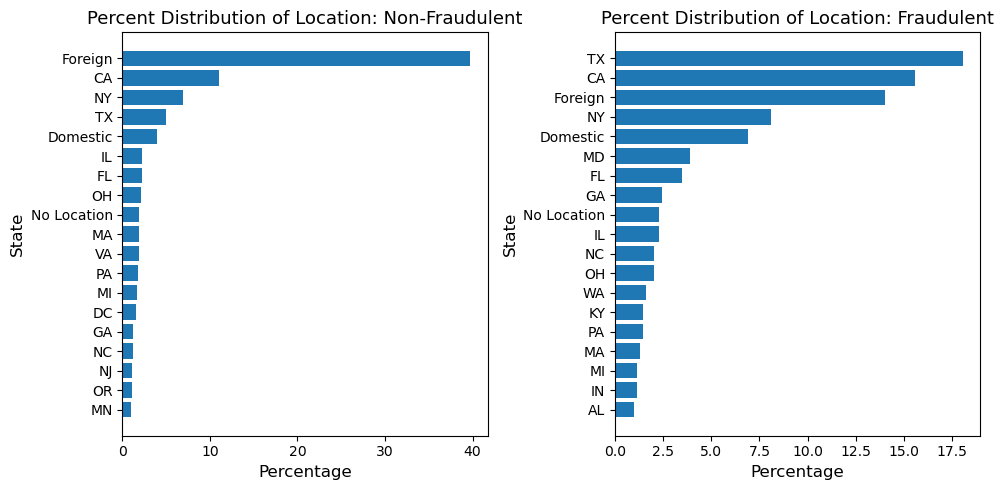

In [298]:
f_sorted_df = f_combined_data.sort_values('percentage')
f_sorted_df = f_sorted_df[f_sorted_df['percentage'] > 1]
x1 = f_sorted_df['state']
y1 = f_sorted_df['percentage']

nf_sorted_df = nf_combined_data.sort_values('percentage')
nf_sorted_df = nf_sorted_df[nf_sorted_df['percentage'] > 1]
x2 = nf_sorted_df['state']
y2 = nf_sorted_df['percentage']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].barh(x2,y2)
axes[0].set_xlabel("Percentage", size=12)
axes[0].set_ylabel("State", size=12)
axes[0].set_title("Percent Distribution of Location: Non-Fraudulent", size=13)

axes[1].barh(x1,y1)
axes[1].set_xlabel("Percentage", size=12)
axes[1].set_ylabel("State", size=12)
axes[1].set_title("Percent Distribution of Location: Fraudulent", size=13)

fig.tight_layout()